# Pattern recognition using DFT

Discrete Fourier Transform, is a mathematical operation used in signal processing and image processing. It transforms a signal or an image from the time or spatial domain into the frequency domain. This transformation represents the signal or image as a sum of sinusoids with different frequencies and amplitudes. In this laboratory, my primary focus will be on constructing an Optical Character Recognition system that leverages the power of Discrete Fourier Transform (DFT) to identify letter patterns within images.

In [114]:
# Useful imports
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import measure
from ocr.pattern_finder import PatternFinder

In [115]:
# Function for presenting images
def show_image(image, title, cmap=None):
    plt.figure(figsize=(9, 5))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Finding a pattern on image

Initially, I will detect distinct patterns within two diverse images.

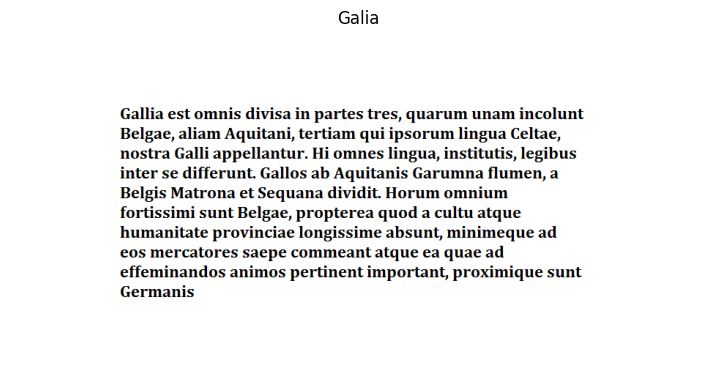

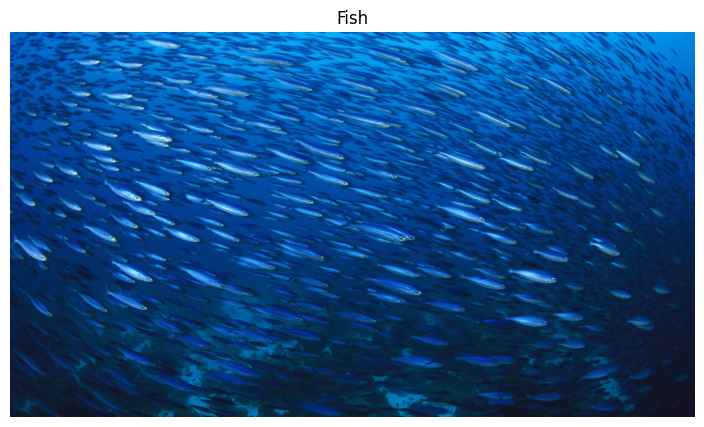

In [116]:
galia = cv2.imread('images/galia.png')
galia = cv2.cvtColor(galia, cv2.COLOR_BGR2RGB)
fish = cv2.imread('images/fish.jpg')
fish = cv2.cvtColor(fish, cv2.COLOR_BGR2RGB)
show_image(galia, 'Galia')
show_image(fish, 'Fish')


Firstly, the images will undergo a transformation to the frequency domain using DFT. To streamline computational complexity and reduce data size, the images will be loaded in greyscale. Given that the background of the text image is white, this will be inverted to enhance contrast.

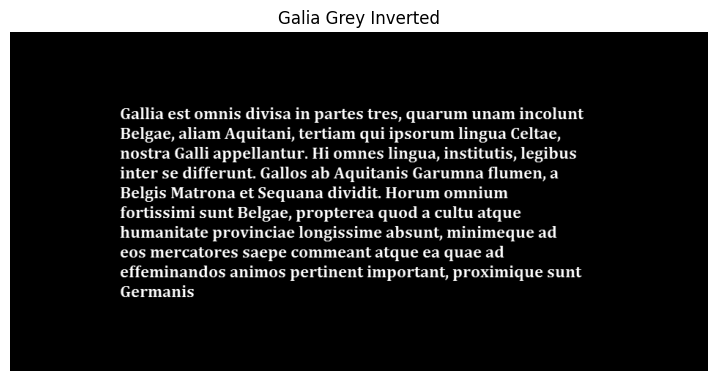

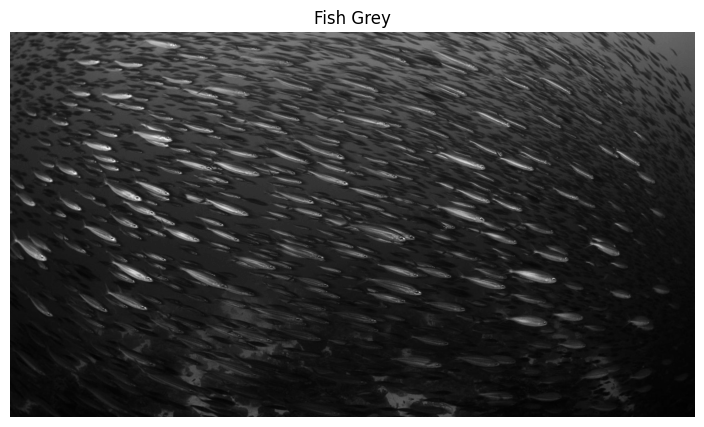

In [117]:
galia_black = cv2.imread('images/galia.png', cv2.IMREAD_GRAYSCALE)
fish_black = cv2.imread('images/fish.jpg', cv2.IMREAD_GRAYSCALE)
galia_inv = cv2.bitwise_not(galia_black)
show_image(galia_inv, 'Galia Grey Inverted', cmap='gray')
show_image(fish_black, 'Fish Grey', cmap='gray')

In [118]:
# Conversion to frequency domain
galia_fft = np.fft.fft2(galia_inv)
fish_fft = np.fft.fft2(fish_black)

# Shifting the zero frequency component to the center
galia_fft_shifted = np.fft.fftshift(galia_fft)
fish_fft_shifted = np.fft.fftshift(fish_fft)

# Magnitude spectrum
galia_magnitude_spectrum = np.abs(galia_fft_shifted)
fish_magnitude_spectrum = np.abs(fish_fft_shifted)

# Phase spectrum
galia_phase_spectrum = np.angle(galia_fft_shifted)
fish_phase_spectrum = np.angle(fish_fft_shifted)

Below are the phase values and magnitudes of Fourier coefficients for the transformed images.

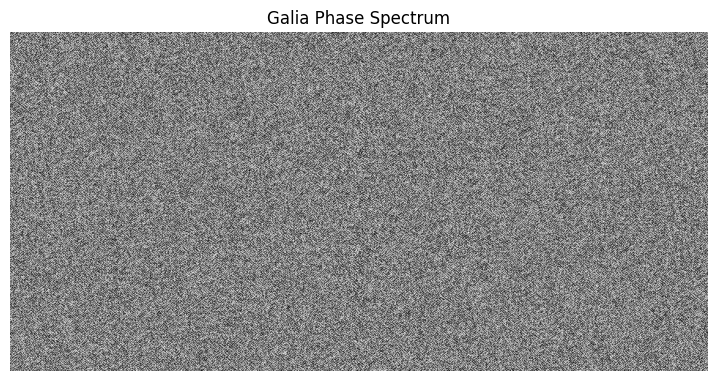

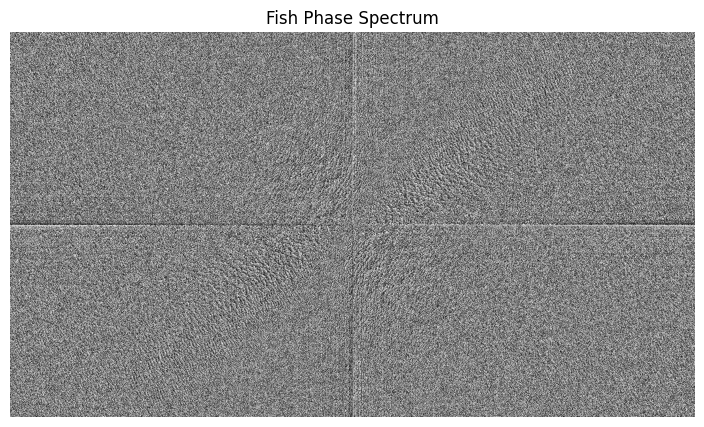

In [119]:
show_image(galia_phase_spectrum, 'Galia Phase Spectrum', cmap='gray')
show_image(fish_phase_spectrum, 'Fish Phase Spectrum', cmap='gray')

The phase value of the Fourier transform serves to encode spatial information about the structure and arrangement of features in an image. It represents the spatial shifts or displacements of frequency components present in the original image. This information is crucial for tasks such as image registration, alignment, and reconstruction. The image depicting the phase values of text is regular, which corresponds to the periodicity of the data. In contrast, we can observe central axis lines and diagonal outlines in the image representing the phase values of the school of fish.

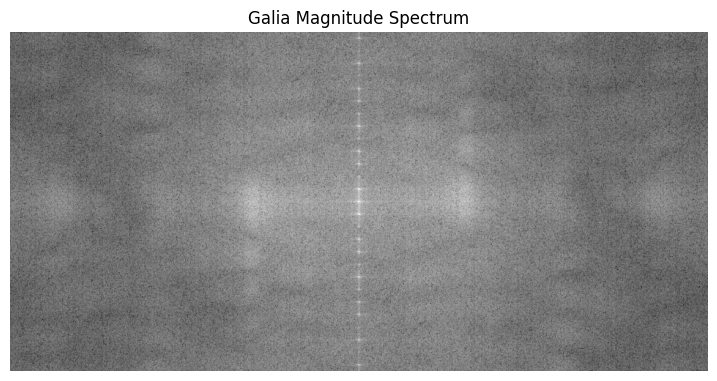

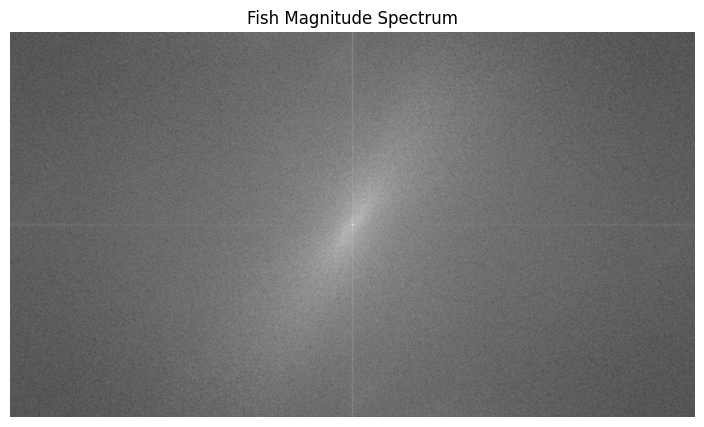

In [120]:
show_image(np.log(galia_magnitude_spectrum), 'Galia Magnitude Spectrum', cmap='gray')
show_image(np.log(fish_magnitude_spectrum), 'Fish Magnitude Spectrum', cmap='gray')

The magnitude value of the Fourier coefficients encodes information about the distribution of spatial frequencies in an image. It represents the amplitude or strength of different frequency components present in the original image. This information is essential for tasks such as filtering, denoising, and compression. In the image representing text, vertical arrangement of higher magnitude values can be observed, which is caused by the horizontal layout of the text. In the image depicting fish, a clearly defined brighter shape arranged diagonally can be noticed, originating from the bright scales of the fish.

Let's direct our attention towards the specific patterns we aim to identify within these images. These patterns will also be loaded in greyscale and transformed into the frequency domain

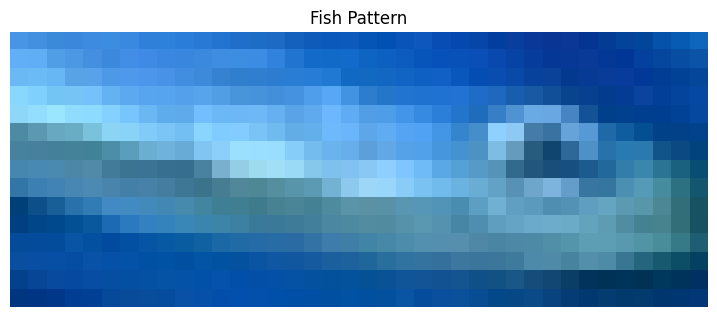

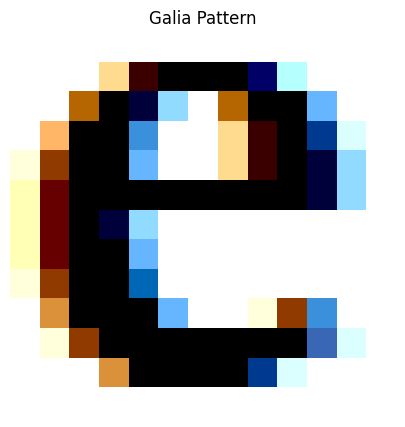

In [121]:
fish_pattern = cv2.imread('images/fish_pattern.png')
fish_pattern = cv2.cvtColor(fish_pattern, cv2.COLOR_BGR2RGB)
galia_pattern = cv2.imread('images/galia_pattern.png')
galia_pattern = cv2.cvtColor(galia_pattern, cv2.COLOR_BGR2RGB)
show_image(fish_pattern, 'Fish Pattern')
show_image(galia_pattern, 'Galia Pattern')

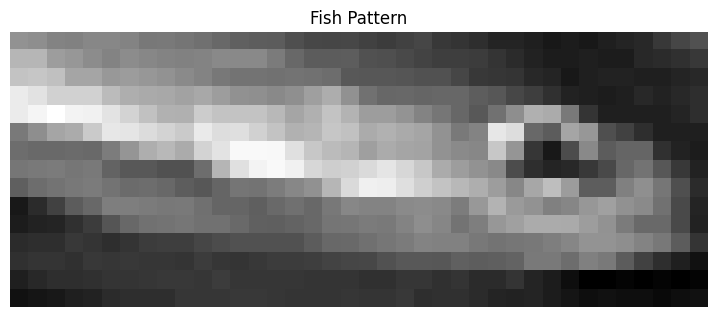

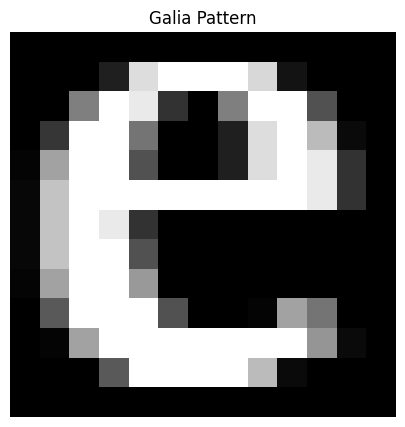

In [122]:
# Loading in grayscale
fish_pattern = cv2.imread('images/fish_pattern.png', cv2.IMREAD_GRAYSCALE)
galia_pattern = cv2.imread('images/galia_pattern.png', cv2.IMREAD_GRAYSCALE)
galia_pattern = cv2.bitwise_not(galia_pattern)
show_image(fish_pattern, 'Fish Pattern', cmap='gray')
show_image(galia_pattern, 'Galia Pattern', cmap='gray')

In [123]:
# Conversion to frequency domain
galia_rotated = np.rot90(galia_pattern, 2)
fish_pattern_fft = np.fft.fft2(fish_pattern, fish_black.shape)
galia_pattern_fft = np.fft.fft2(galia_rotated, galia_black.shape)

To discover patterns within the images, we'll compute correlations by multiplying their frequency domain representations.

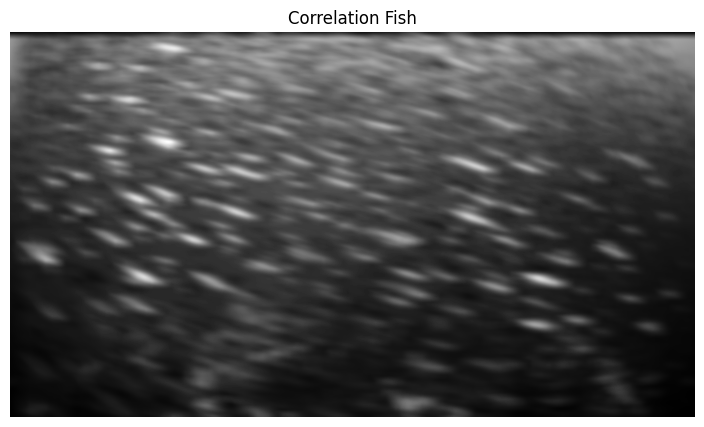

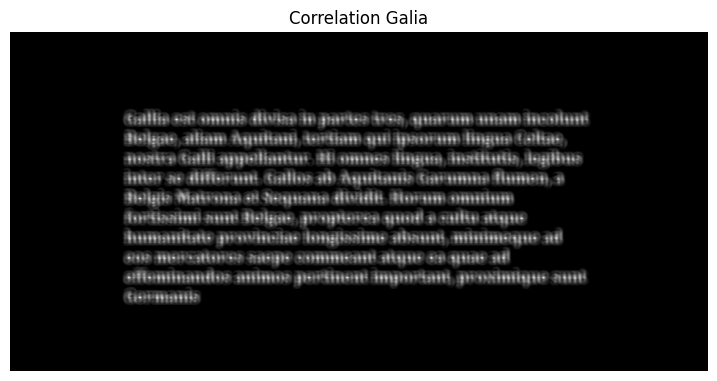

In [124]:
correlation_fish = np.real(np.fft.ifft2(np.multiply(fish_fft, fish_pattern_fft)))
correlation_galia = np.real(np.fft.ifft2(np.multiply(galia_fft, galia_pattern_fft)))
show_image(correlation_fish, 'Correlation Fish', cmap='gray')
show_image(correlation_galia, 'Correlation Galia', cmap='gray')

Filtering the correlation matrix with the maximum correlation value allows us to pinpoint all potential instances of the pattern within the image. Setting the appropriate sensitivity is crucial for achieving our objective. For precise matches akin to text processing, a high sensitivity threshold (e.g., 90% of the maximum correlation value) is necessary. Conversely, when seeking similar images (e.g., multiple fishes), a lower sensitivity threshold can be employed. Determining the optimal sensitivity is paramount in the pattern recognition process.

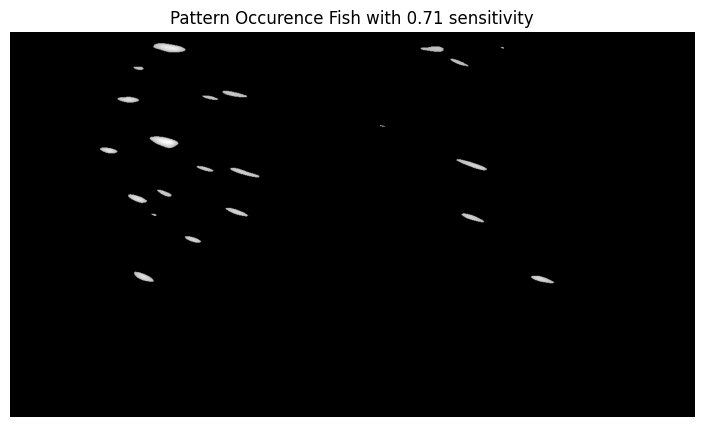

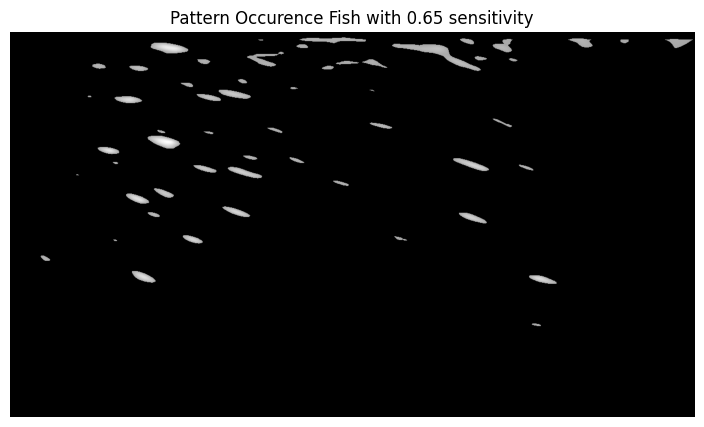

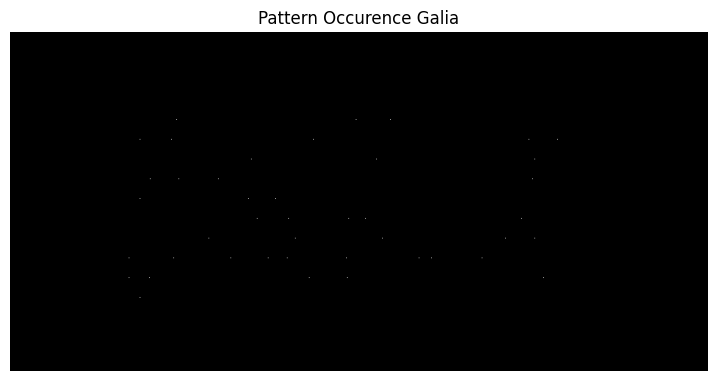

In [125]:
sensitivity_fish_1 = 0.71
sensitivity_fish_2 = 0.65
sensitivity_galia = 0.9

filtered_correlation_fish_1 = np.where(correlation_fish > np.max(correlation_fish)* sensitivity_fish_1, correlation_fish, 0)
filtered_correlation_fish_2 = np.where(correlation_fish > np.max(correlation_fish)* sensitivity_fish_2, correlation_fish, 0)
filtered_correlation_galia = np.where(correlation_galia > np.max(correlation_galia)* sensitivity_galia, correlation_galia, 0)
show_image(filtered_correlation_fish_1, 'Pattern Occurence Fish with 0.71 sensitivity', cmap='gray')
show_image(filtered_correlation_fish_2, 'Pattern Occurence Fish with 0.65 sensitivity', cmap='gray')
show_image(filtered_correlation_galia, 'Pattern Occurence Galia', cmap='gray')

In [126]:
# Functions for getting places of pattern occurence. Occurences in the same area are considered to be the same elements.
def get_pattern_occurence(correlation, pattern):
    pattern_set = set()
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            if correlation[i, j] > 0 and not check_pattern(i, j, pattern_set, pattern):
                pattern_set.add((i, j))

    return pattern_set

def check_pattern(i, j, lett_set, pattern):
    for (i1, j1) in lett_set:
        if abs(i - i1) < pattern.shape[0] and abs(j - j1) < pattern.shape[1]:
            return True
    return False

In [127]:
# Function for showing images with blended patterns
def show_with_patterns_blend(image, filtered_image, sensitivity):
    number = len(measure.find_contours(filtered_image, sensitivity* np.max(filtered_image)))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if filtered_image[i, j] > 0:
                image[i, j] = (255, 0, 0)
    show_image(image, f'Image with patterns, number of elements: {number}')

In [128]:
# Function for showing images with squares around patterns
def show_with_patterns_squares(image, pattern_set, pattern):
    for i, j in pattern_set:
        cv2.rectangle(image, (j- pattern.shape[1], i- pattern.shape[0]), (j, i), (255, 0, 0), 2)
    show_image(image, f'Image with patterns, number of elements: {len(pattern_set)}')

Now we can observe that our pattern has been successfully recognized in the images

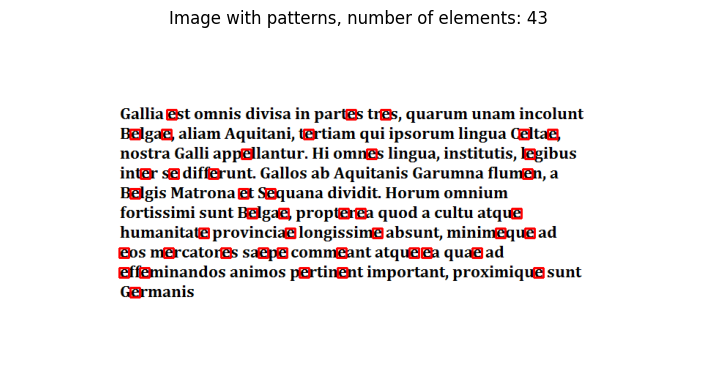

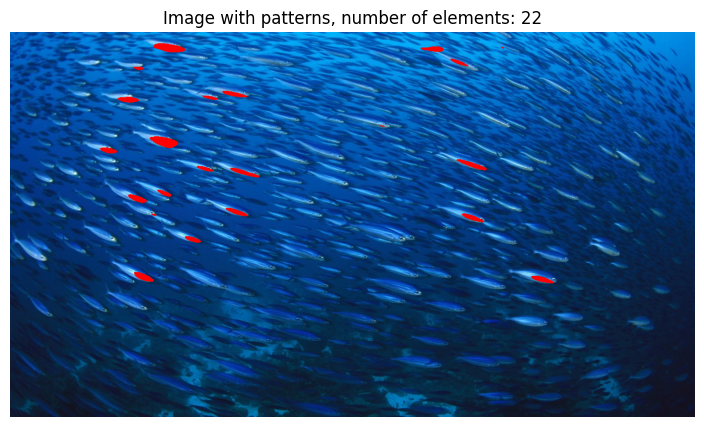

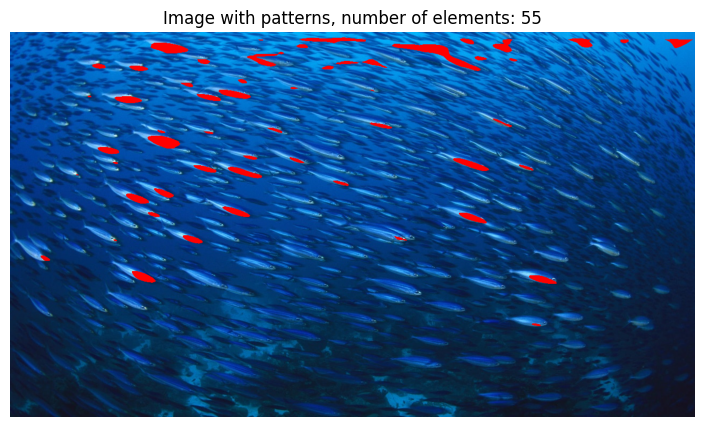

In [129]:
pattern_occurence_galia = get_pattern_occurence(filtered_correlation_galia, galia_pattern)
show_with_patterns_squares(galia, pattern_occurence_galia, galia_pattern)
show_with_patterns_blend(fish, filtered_correlation_fish_1, sensitivity_fish_1)
show_with_patterns_blend(fish, filtered_correlation_fish_2, sensitivity_fish_2)